In [1]:
import phys
import phys.newton
import phys.light
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class ScatterDeleteStep2(phys.Step):
    def __init__(self, n, A):
        self.n = n
        self.A = A
        self.built = False
        
    def run(self, sim):
        if self.built != True:
            skip = phys.CLInput(name="photon_check", type="obj_action", code="if type(obj) != phys.light.PhotonObject:\n \t\t continue")
            d0, d1, d2 = tuple([phys.CLInput(name="d" + str(x), type="obj", obj_attr="dr[" + str(x) + "]") for x in range(0, 3)])
            rand = phys.CLInput(name="rand", type="obj_def", obj_def="np.random.random()")
            A_, n_ = phys.CLInput(name="A", type="const", const_value=str(self.n)), phys.CLInput(name="n", type="const", const_value=str(self.A))
            pht = phys.CLInput(name="pht", type="obj_track", obj_track="obj")
            res = phys.CLOutput(name="res", ctype="int")
            kernel = """
                int gid = get_global_id(0);
                    double norm = sqrt(pow(d0[gid], 2) + pow(d1[gid], 2) + pow(d2[gid], 2));
                    double pcoll = A * n * norm;
                    if (pcoll >= rand[gid]){
                        // Mark for removal.
                        res[gid] = 1;
                    } else {
                        res[gid] = 0;
                    }
                """
            
            self.prog = phys.CLProgram(sim, "test", kernel)
            self.prog.prep_metadata = [skip, d0, d1, d2, rand, pht, A_, n_]
            self.prog.output_metadata = [res]
            self.prog.build_kernel()
            self.built = True
        
        out = self.prog.run()
        for idx, x in enumerate(out["res"]):
            if x == 1:
                sim.remove_obj(self.prog.pht[idx])

def new_sim(step, n):
    sim = phys.Simulation({"cl_on": True})
    sim.add_objs(phys.light.generate_photons_from_E(np.linspace(phys.Measurement(5e-19, "J**1"), phys.Measurement(1e-18, "J**1"), 1000)))
    sim.exit = lambda cond: len(cond.objects) == 0
    sim.add_step(0, phys.UpdateTimeStep(lambda s: phys.Measurement(np.double(0.001), "s**1")))
    sim.add_step(1, phys.newton.NewtonianKinematicsStep())
    A = np.double(0.001)
    n = np.double(0.001)
    sim.add_step(2, step(n, A))
    sim.add_step(3, phys.light.ScatterMeasureStep(None, True))
    return sim

Testing old 100.0


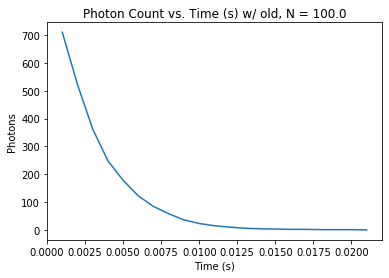

Testing new 100.0
Testing old 237.0


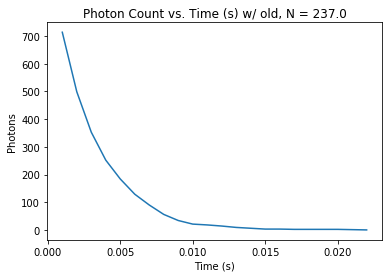

Testing new 237.0
Testing old 562.0


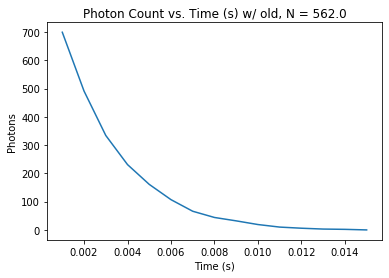

Testing new 562.0
Testing old 1333.0


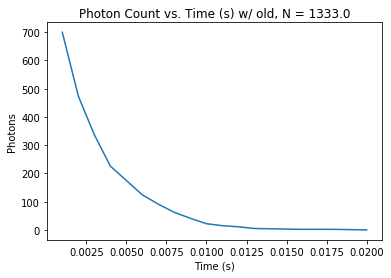

Testing new 1333.0
Testing old 3162.0


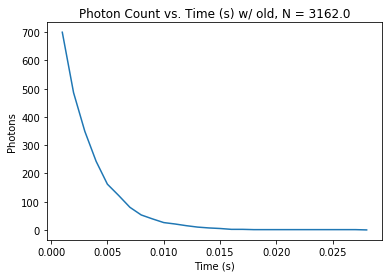

Testing new 3162.0
Testing old 7498.0


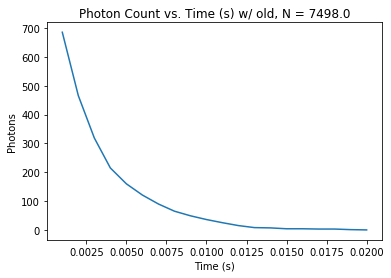

Testing new 7498.0
Testing old 17782.0


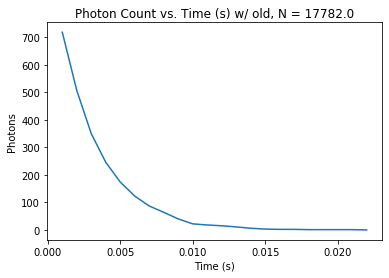

Testing new 17782.0
Testing old 42169.0


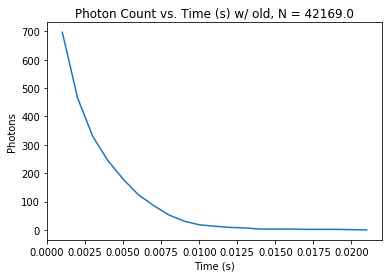

Testing new 42169.0
Testing old 100000.0


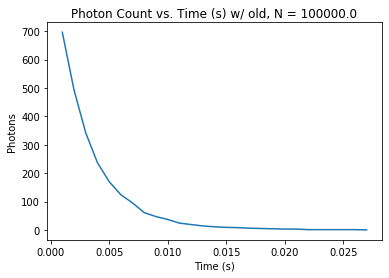

Testing new 100000.0


In [2]:
orig, new = [], []
ns = np.floor(10 ** np.linspace(2, 5, 9))
for i in ns:
    print("Testing old " + str(i))
    o = new_sim(phys.light.ScatterDeleteStepReference, int(i))
    o.start()
    o.join()
    orig.append(o.run_time)
    plt.plot(o.ts, [x[1] for x in o.steps[3].data], label="n")
    plt.ylabel("Photons")
    plt.xlabel("Time (s)")
    plt.title("Photon Count vs. Time (s) w/ old, N = " + str(i))
    plt.show()
        
    
    print("Testing new " + str(i))
    n = new_sim(ScatterDeleteStep2, int(i))
    n.start()
    n.join()
    new.append(n.run_time)

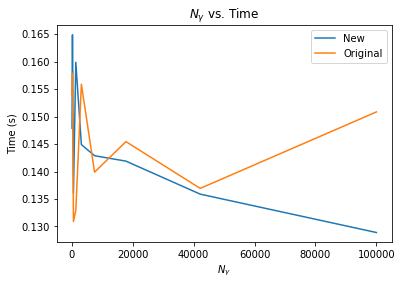

In [3]:
plt.plot(ns, new, label="New")
plt.plot(ns, orig, label="Original")
plt.legend()
plt.xlabel("$N_\gamma$")
plt.ylabel("Time (s)")
plt.title("$N_\gamma$ vs. Time")
plt.show()

In [11]:
o.ts[0].size

1